<a href="https://colab.research.google.com/github/sharjeel-png/CP33_TEAM_B_Evoastra_Mini_Project/blob/main/EVOASTRA__MINI_PROJECT_%5B_CP33_TEAM_B_%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---


**EVOASTRA_ MINI_PROJECT [ CP33_TEAM_B ]**

---





---


**NOTE : -  WHATEVER YOU WILL EDIT HERE WILL BE REFLECTED TO ALL TEAM MEMBERS , PLEASE DO NOT EDIT 1st 3 CELLS FROM TOP.**


---



**Mini Project: Web Scraping Car Details from Cars24.com**

---



**Project Objective:**

    The objective of this mini-project is to develop skills in web scraping
    by extracting and analyzing car details from Cars24.com.

    Interns will focus on gathering data specific to the Mumbai location
    covering key details such as kilometers driven, year of manufacture,
    fuel type, transmission, and price.

    By the end of this project, interns will have hands-on experience in
    web scraping, data cleaning, and presenting structured data for analysis.


---




**Project Requirements:**

**1) Scraping Target: Cars listed on Cars24.com from three locations.**


**2) Data to Collect:**

       1. Kilometers Driven

       2. Year of Manufacture

       3. Fuel Type

       4. Transmission

       5. Price


---





**3. Assigned Brands: Each team will scrape data for a specific car brand.**


    **Brand Assignments:**

        Team A: Toyota

        **Team B: Honda [ TEAM B OBJECTIVE ]**

        Team C: Hyundai

        Team D: Maruti Suzuki

        Team E: Tata

        Team F: Ford

        Team G: Mahindra


---







**Steps to Follow:**


**1) Research and Planning:**

      Understand the structure of Cars24.com.

      Identify the HTML elements containing the required information.


**2) Data Extraction:**

      Write a script to scrape the necessary details
      (kilometers driven, year of manufacture, fuel type, transmission, and price) for the assigned brand.


**3) Data Cleaning:**

      Ensure the scraped data is clean and organized for analysis.


**4) Data Presentation:**

      Present the collected data in a structured format in a CSV.



**Special Instructions:**


    If the cars for the specific assigned brand are not available in the Mumbai location,
    change the location to scrape data for that particular brand only.

    Ensure to document any location changes and reasons for doing so.


**Deliverables:**


**1) Python Notebook:**

    A well-documented .ipynb notebook used for the web scraping project.



**2) Presentation file:**

    The presentation file must be converted into a pdf before submissions


**3) Report**

    A brief report detailing the process, any challenges faced, solutions
    implemented, and insights gained from the data.



**Note:**

    Ensure compliance with ethical guidelines and the website's terms of service while scraping data.

    Work collaboratively within your teams and reach out to mentors if you encounter any challenges.


    This project is designed to equip you with practical skills in webscraping, data management, and
    analysis, providing a solid foundation for your career in data science.


**Good luck, and happy scraping!**



---



---
**SOLUTION**


---



---



**STEP 1 - INSTALLING DEPENDENCIES**

In [ ]:
!pip install selenium
!pip install pandas

**STEP 2 - IMPORTING THE LIBRARIES**

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
import time
import pandas as pd
import re

**STEP 3 - DEFINING THE FUNCTIONS**

In [ ]:
class Cars24Scraper:
    def __init__(self):
        # Setup Chrome options
        chrome_options = Options()
        chrome_options.add_argument("--no-sandbox")
        chrome_options.add_argument("--disable-dev-shm-usage")
        chrome_options.add_argument("--disable-blink-features=AutomationControlled")
        chrome_options.add_experimental_option("excludeSwitches", ["enable-automation"])
        chrome_options.add_experimental_option('useAutomationExtension', False)
        chrome_options.add_argument("--headless") # Add this line for headless mode

        # Initialize the driver
        self.driver = webdriver.Chrome(options=chrome_options)
        self.driver.execute_script("Object.defineProperty(navigator, 'webdriver', {get: () => undefined})")

    def slow_scroll_until_all_loaded(self, max_scroll_attempts=30, scroll_pause_time=2):
        """
        Keep scrolling until no new cars are loaded or max attempts reached
        """
        previous_count = 0
        no_new_cars_count = 0

        for attempt in range(max_scroll_attempts):
            # Get current count of car elements
            current_cars = self.driver.find_elements(By.CSS_SELECTOR, "div.styles_outer__NTVth")
            current_count = len(current_cars)

            print(f"Scroll {attempt+1}/{max_scroll_attempts} - Found {current_count} cars so far")

            # Check if we're getting new cars
            if current_count == previous_count:
                no_new_cars_count += 1
                print(f"No new cars loaded this scroll ({no_new_cars_count}/3)")
            else:
                no_new_cars_count = 0
                print(f"New cars loaded! +{current_count - previous_count}")

            # If no new cars for 3 consecutive scrolls, stop
            if no_new_cars_count >= 3:
                print("No new cars loaded for 3 consecutive scrolls. Stopping.")
                break

            previous_count = current_count

            # Scroll down gradually
            scroll_increment = 800  # Slightly larger increment
            current_position = self.driver.execute_script("return window.pageYOffset;")
            target_position = current_position + scroll_increment
            total_height = self.driver.execute_script("return document.body.scrollHeight;")

            # Scroll to target position
            self.driver.execute_script(f"window.scrollTo({{top: {target_position}, behavior: 'smooth'}});")

            # Wait for content to load
            time.sleep(scroll_pause_time)

            # Try to scroll to bottom if we're close
            if target_position >= total_height - 1000:
                self.driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                time.sleep(scroll_pause_time)

    def scroll_to_bottom_and_back(self, scroll_times=15):
        """
        Alternative method: Scroll to bottom multiple times
        """
        for i in range(scroll_times):
            print(f"Scroll pass {i+1}/{scroll_times}")

            # Scroll to bottom smoothly
            self.driver.execute_script("window.scrollTo({top: document.body.scrollHeight, behavior: 'smooth'});")
            time.sleep(3)  # Wait for content to load

            # Scroll up a bit to trigger loading
            self.driver.execute_script("window.scrollBy(0, -300);")
            time.sleep(1)

            # Get current count
            current_cars = self.driver.find_elements(By.CSS_SELECTOR, "div.styles_outer__NTVth")
            print(f"Current car count: {len(current_cars)}")

    def extract_price(self, car_element):
        """
        Extract and clean price information
        Handles both scenarios:
        Scenario 1: "₹10.25L\n₹8.47 lakh" -> extract "₹8.47 lakh"
        Scenario 2: "₹3.30 lakh" -> keep as is
        """
        try:
            # Find all price elements
            price_elements = car_element.find_elements(By.CSS_SELECTOR, "p.sc-braxZu.gbxhkm, p.sc-braxZu.cyPhJl")

            if not price_elements:
                return "N/A"

            # Get all price texts
            price_texts = [elem.text for elem in price_elements if elem.text.strip()]

            if not price_texts:
                return "N/A"

            # Strategy 1: Look for the price that contains "lakh" (preferred)
            lakh_prices = [price for price in price_texts if 'lakh' in price.lower()]
            if lakh_prices:
                return lakh_prices[0]  # Return the first price with "lakh"

            # Strategy 2: If no "lakh" prices, look for prices with "L" (like 10.25L)
            l_prices = [price for price in price_texts if 'L' in price]
            if l_prices:
                return l_prices[0]  # Return the first price with "L"

            # Strategy 3: If multiple prices without clear indicators, take the last one
            # (usually the discounted/actual price comes second)
            if len(price_texts) > 1:
                return price_texts[-1]  # Return the last price

            # Strategy 4: If only one price, return it
            return price_texts[0]

        except Exception as e:
            print(f"Error extracting price: {str(e)}")
            return "N/A"

    def extract_car_details(self, car_element):
        """
        Extract car details from a single car element
        """
        try:
            # Car Name
            name_element = car_element.find_element(By.CSS_SELECTOR, "span.sc-braxZu.kjFjan")
            car_name = name_element.text if name_element else "N/A"
        except:
            car_name = "N/A"

        try:
            # Car Variant
            variant_element = car_element.find_element(By.CSS_SELECTOR, "span.sc-braxZu.lmmumg")
            car_variant = variant_element.text if variant_element else "N/A"
        except:
            car_variant = "N/A"

        # Full car name
        full_car_name = f"{car_name} {car_variant}".strip()

        # Extract details from the list items
        details = {}
        try:
            detail_elements = car_element.find_elements(By.CSS_SELECTOR, "p.sc-braxZu.kvfdZL")
            details_list = [elem.text for elem in detail_elements]

            # Assuming the order is: Kilometers, Fuel Type, Transmission, Location
            if len(details_list) >= 4:
                details['kilometers'] = details_list[0]
                details['fuel_type'] = details_list[1]
                details['transmission'] = details_list[2]
            elif len(details_list) == 3:
                details['kilometers'] = details_list[0]
                details['fuel_type'] = details_list[1]
                details['transmission'] = details_list[2]
            else:
                details['kilometers'] = details_list[0] if len(details_list) > 0 else "N/A"
                details['fuel_type'] = details_list[1] if len(details_list) > 1 else "N/A"
                details['transmission'] = details_list[2] if len(details_list) > 2 else "N/A"

        except:
            details = {'kilometers': 'N/A', 'fuel_type': 'N/A', 'transmission': 'N/A'}

        # Extract Year from car name (first 4 digits)
        try:
            year = car_name[:4] if car_name and car_name[:4].isdigit() else "N/A"
        except:
            year = "N/A"

        # Extract Price using the dedicated price extraction method
        price = self.extract_price(car_element)

        return {
            'name': full_car_name,
            'year': year,
            'kilometers': details.get('kilometers', 'N/A'),
            'fuel_type': details.get('fuel_type', 'N/A'),
            'transmission': details.get('transmission', 'N/A'),
            'price': price
        }

    def scrape_cars(self, url):
        """
        Main function to scrape car details from the given URL
        """
        try:
            # Navigate to the URL
            print(f"Navigating to: {url}")
            self.driver.get(url)

            # Wait for the page to load initially
            time.sleep(5)

            # Method 1: Scroll until all content is loaded
            print("Starting intelligent scrolling to load all cars...")
            self.slow_scroll_until_all_loaded(max_scroll_attempts=30, scroll_pause_time=2)

            # Method 2: Additional scroll to bottom multiple times
            print("Performing additional scroll passes...")
            self.scroll_to_bottom_and_back(scroll_times=5)

            # Final wait after all scrolling
            time.sleep(3)

            # Find all car elements
            car_elements = self.driver.find_elements(By.CSS_SELECTOR, "div.styles_outer__NTVth")

            print(f"Final count: Found {len(car_elements)} car elements")

            # Extract data from each car element
            cars_data = []
            for i, car_element in enumerate(car_elements):
                try:
                    print(f"Processing car {i+1}/{len(car_elements)}")
                    car_data = self.extract_car_details(car_element)
                    cars_data.append(car_data)

                    # Print progress with price for verification
                    print(f"  - {car_data['name'][:30]}... | Price: {car_data['price']}")

                except Exception as e:
                    print(f"Error processing car {i+1}: {str(e)}")
                    continue

            return cars_data

        except Exception as e:
            print(f"Error during scraping: {str(e)}")
            return []

    def save_to_csv(self, data, filename="cars24_data.csv"):
        """
        Save scraped data to CSV file
        """
        if data:
            df = pd.DataFrame(data)
            df.to_csv(filename, index=False)
            print(f"Data saved to {filename}")
            return df
        else:
            print("No data to save")
            return None

    def close(self):
        """
        Close the browser
        """
        self.driver.quit()

**STEP 4 - EXECUTING THE SCRAPING USING DEFINED FUNCTIONS**

In [ ]:
# Main execution
if __name__ == "__main__":
    # Initialize the scraper
    scraper = Cars24Scraper()

    try:
        # URL to scrape
        url = "https://www.cars24.com/buy-used-honda-cars-mumbai/?sort=bestmatch&serveWarrantyCount=true&listingSource=TabFilter&storeCityId=2378"

        # Scrape the data
        cars_data = scraper.scrape_cars(url)

        # Display results
        if cars_data:
            print(f"\nSuccessfully scraped {len(cars_data)} cars")
            print("\nSample of cars with different price formats:")

            # Show examples of different price formats
            price_examples = {}
            for car in cars_data:
                price = car['price']
                if price not in price_examples:
                    price_examples[price] = car['name']
                    if len(price_examples) >= 5:  # Show 5 different price formats
                        break

            for i, (price, name) in enumerate(price_examples.items()):
                print(f"{i+1}. {name[:40]}... | Price: {price}")

            # Save to CSV
            # scraper.save_to_csv(cars_data, "CP33_TEAM_B_cars24_complete_data.csv" )
            df_cars = pd.DataFrame(cars_data)
            # df_cars.head(200)
            print(df_cars)
        else:
            print("No data scraped")

    except Exception as e:
        print(f"Error: {str(e)}")

    finally:
        # Close the browser
        scraper.close()

Navigating to: https://www.cars24.com/buy-used-honda-cars-mumbai/?sort=bestmatch&serveWarrantyCount=true&listingSource=TabFilter&storeCityId=2378
Starting intelligent scrolling to load all cars...
Scroll 1/30 - Found 20 cars so far
New cars loaded! +20
Scroll 2/30 - Found 20 cars so far
No new cars loaded this scroll (1/3)
Scroll 3/30 - Found 20 cars so far
No new cars loaded this scroll (2/3)
Scroll 4/30 - Found 40 cars so far
New cars loaded! +20
Scroll 5/30 - Found 40 cars so far
No new cars loaded this scroll (1/3)
Scroll 6/30 - Found 40 cars so far
No new cars loaded this scroll (2/3)
Scroll 7/30 - Found 60 cars so far
New cars loaded! +20
Scroll 8/30 - Found 60 cars so far
No new cars loaded this scroll (1/3)
Scroll 9/30 - Found 60 cars so far
No new cars loaded this scroll (2/3)
Scroll 10/30 - Found 80 cars so far
New cars loaded! +20
Scroll 11/30 - Found 80 cars so far
No new cars loaded this scroll (1/3)
Scroll 12/30 - Found 80 cars so far
No new cars loaded this scroll (2/3)


**STEP 5 - PRESENTING THE SCRAPED DATA IN DATAFRAME**

In [ ]:
df_cars = pd.DataFrame(cars_data)
df_cars

,name,year,kilometers,fuel_type,transmission,price
0,2021 Honda City,2021,39.56k km,Petrol,Auto,₹8.47 lakh
1,2015 Honda Amaze,2015,54.64k km,Petrol,Auto,₹3.30 lakh
2,2021 Honda Amaze,2021,46.24k km,Petrol,Manual,₹6.00 lakh
3,2019 Honda City,2019,76.64k km,Petrol,Auto,₹6.80 lakh
4,2014 Honda Brio VX MT,2014,28.41k km,Petrol,Manual,₹2.56 lakh
...,...,...,...,...,...,...
189,2011 Honda Brio V MT,2011,63.13k km,Petrol,Manual,₹1.50 lakh
190,2013 Honda Accord,2013,83.00k km,Petrol,Manual,₹2.90 lakh
191,2018 Honda City,2018,47.43k km,Petrol,Manual,₹5.07 lakh
192,2012 Honda Brio S MT,2012,46.46k km,Petrol,Manual,₹1.65 lakh


# Save to CSV [ uncleaned data ]

In [ ]:
# Save to CSV [ uncleaned data ]
scraper.save_to_csv(cars_data, "CP33_TEAM_B_cars24_complete_data.csv" )

Data saved to CP33_TEAM_B_cars24_complete_data.csv


,name,year,kilometers,fuel_type,transmission,price
0,2021 Honda City,2021,39.56k km,Petrol,Auto,₹8.47 lakh
1,2015 Honda Amaze,2015,54.64k km,Petrol,Auto,₹3.30 lakh
2,2021 Honda Amaze,2021,46.24k km,Petrol,Manual,₹6.00 lakh
3,2019 Honda City,2019,76.64k km,Petrol,Auto,₹6.80 lakh
4,2014 Honda Brio VX MT,2014,28.41k km,Petrol,Manual,₹2.56 lakh
...,...,...,...,...,...,...
189,2011 Honda Brio V MT,2011,63.13k km,Petrol,Manual,₹1.50 lakh
190,2013 Honda Accord,2013,83.00k km,Petrol,Manual,₹2.90 lakh
191,2018 Honda City,2018,47.43k km,Petrol,Manual,₹5.07 lakh
192,2012 Honda Brio S MT,2012,46.46k km,Petrol,Manual,₹1.65 lakh


**STEP 5 - CLEANING THE SCRAPED DATA**

# STEP 5.1 — Helper parsers for kilometers and price (₹ in lakh), and standardizers for fuel/transmission

In [ ]:
# STEP 5.1 — Helper parsers for kilometers and price (₹ in lakh), and standardizers for fuel/transmission


def parse_kilometers(x: str) -> float:
    """
    Convert strings like '39.56k km', '1.2L km', '1.0L km', '50000 km' -> integer km.
    'k' = ×1,000 ; 'L' = ×100,000 (lakh, Indian numbering).
    Returns np.nan if it cannot parse.
    """
    if pd.isna(x):
        return np.nan
    # normalize: remove commas, trim, lower-case
    s = str(x).strip().replace(",", "").lower()
    # typical patterns: '39.56k km', '1.2l km'
    m = re.match(r'^\s*([\d\.]+)\s*([kl])\s*km\s*$', s)
    if m:
        val = float(m.group(1))
        unit = m.group(2)
        factor = 1000 if unit == 'k' else 100000
        return int(round(val * factor))
    # fallback: plain number followed by 'km' (e.g., '50000 km')
    m2 = re.match(r'^\s*([\d\.]+)\s*km\s*$', s)
    if m2:
        return int(round(float(m2.group(1))))
    return np.nan

def parse_price_inr(x: str) -> float:
    """
    Convert '₹8.47 lakh' -> 847000 (INR).
    Assumes quoted in lakh; falls back to a plain trailing number if present.
    """
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower().replace(",", "")
    # accept variants like '₹8.47 lakh', 'rs 8.47 lakh'
    m = re.search(r'([\d\.]+)\s*lakh', s)
    if m:
        lakhs = float(m.group(1))
        return int(round(lakhs * 100000))
    # fallback: take trailing number if any
    m2 = re.search(r'([\d\.]+)\s*$', s)
    if m2:
        return int(round(float(m2.group(1))))
    return np.nan

def transmission(x: str) -> str:
    """Normalize transmission labels to 'Automatic' / 'Manual'."""
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    if s in {"auto", "automatic", "cvt", "amt", "dct"}:
        return "Automatic"
    if s in {"manual", "mt"}:
        return "Manual"
    # default: keep a clean title-cased value
    return str(x).strip().title()

def fuel(x: str) -> str:
    """Standardize fuel types."""
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    mapping = {
        "petrol": "Petrol",
        "diesel": "Diesel",
        "cng": "CNG",
        "electric": "Electric",
        "hybrid": "Hybrid",
    }
    return mapping.get(s, str(x).strip().title())



# STEP 5.2 — Apply parsers/standardizers to your raw dataframe

In [ ]:
# STEP 5.2 ---- Apply parsers/standardizers to your raw dataframe ----

df = df_cars.copy()

df["kilometers_num"]   = df["kilometers"].apply(parse_kilometers)
df["price_inr"]        = df["price"].apply(parse_price_inr)
df["transmission"] = df["transmission"].apply(transmission)
df["fuel"]         = df["fuel_type"].apply(fuel)

df


,name,year,kilometers,fuel_type,transmission,price,kilometers_num,price_inr,fuel
0,2021 Honda City,2021,39.56k km,Petrol,Automatic,₹8.47 lakh,39560,847000,Petrol
1,2015 Honda Amaze,2015,54.64k km,Petrol,Automatic,₹3.30 lakh,54640,330000,Petrol
2,2021 Honda Amaze,2021,46.24k km,Petrol,Manual,₹6.00 lakh,46240,600000,Petrol
3,2019 Honda City,2019,76.64k km,Petrol,Automatic,₹6.80 lakh,76640,680000,Petrol
4,2014 Honda Brio VX MT,2014,28.41k km,Petrol,Manual,₹2.56 lakh,28410,256000,Petrol
...,...,...,...,...,...,...,...,...,...
189,2011 Honda Brio V MT,2011,63.13k km,Petrol,Manual,₹1.50 lakh,63130,150000,Petrol
190,2013 Honda Accord,2013,83.00k km,Petrol,Manual,₹2.90 lakh,83000,290000,Petrol
191,2018 Honda City,2018,47.43k km,Petrol,Manual,₹5.07 lakh,47430,507000,Petrol
192,2012 Honda Brio S MT,2012,46.46k km,Petrol,Manual,₹1.65 lakh,46460,165000,Petrol


# STEP 5.3 Basic sanity checks (quick data health report)

In [ ]:
# Coerce year to integer (nullable Int64 so missing stays as <NA>)
df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")

# ---- Basic sanity checks (quick data health report) ----
summary = {
    "rows": len(df),                                           # total rows after parsing
    "missing_km": int(df["kilometers_num"].isna().sum()),      # km that failed to parse
    "missing_price": int(df["price_inr"].isna().sum()),        # price that failed to parse
    "missing_year": int(df["year"].isna().sum()),              # year that failed to parse
}

summary

{'rows': 194, 'missing_km': 0, 'missing_price': 0, 'missing_year': 0}

# STEP 5.3–5.7 — FINAL CLEANING (simplified)

In [ ]:
# ============================================
# STEP 5.3–5.7 — FINAL CLEANING (simplified)
# ============================================

# --- Extract brand & model from `name` ---
KNOWN_MODELS = ["City","Amaze","Jazz","Brio","WR-V","BR-V","Mobilio",
                "Accord","CRV","CR-V","ELEVATE","Elevate","BRV","WRV"]

def extract_model(name: str) -> str:
    if pd.isna(name): return np.nan
    s = str(name)
    for m in KNOWN_MODELS:
        if re.search(rf'\b{re.escape(m)}\b', s, flags=re.IGNORECASE):
            return (m.upper()
                      .replace("BRV","BR-V")
                      .replace("WRV","WR-V")
                      .replace("CRV","CR-V"))
    return np.nan

def extract_brand(name: str) -> str:
    if pd.isna(name): return np.nan
    for token in str(name).split():
        if not re.match(r'^\d{4}$', token):
            return token.title()
    return np.nan

df["brand"] = df["name"].apply(extract_brand)
df.loc[df["brand"].str.lower() == "honda", "brand"] = "Honda"
df["model"] = df["name"].apply(extract_model)

# --- Derived column: Age of car as of 2025 ---
CURRENT_YEAR = 2025
df["age_years_2025"] = (CURRENT_YEAR - df["year"].astype(float)).astype("Int64")

# --- Remove duplicates ---
df = df.drop_duplicates(subset=["name","year","kilometers","fuel_type","transmission","price"])

# --- Light range filters (for valid data only) ---
df_cars_clean = df[
    (df["kilometers_num"].between(0, 600000, inclusive="both")) &
    (df["price_inr"].between(80000, 20000000, inclusive="both"))
].copy()

# --- Final column order (simplified) ---
final_cols = [
    "brand","model","name","year",
    "fuel_type","transmission",
    "kilometers_num","price_inr","age_years_2025",
    "kilometers","price"
]

df_cars_clean = (df_cars_clean[final_cols]
                 .sort_values(by=["model","year","kilometers_num"], ascending=[True, False, True])
                 .reset_index(drop=True))

# --- Final sanity snapshot ---
final_sanity = {
    "rows_clean": len(df_cars_clean),
    "null_km": int(df_cars_clean["kilometers_num"].isna().sum()),
    "null_price": int(df_cars_clean["price_inr"].isna().sum()),
    "null_year": int(df_cars_clean["year"].isna().sum()),
}
final_sanity


{'rows_clean': 194, 'null_km': 0, 'null_price': 0, 'null_year': 0}

# STEP 6.2 — SAVE FINAL CLEANED DATA TO CSV

In [ ]:
# df_cars_clean = df_cars_clean.drop(['kilometers'], axis=1)
# df_cars_clean = df_cars_clean.drop(['price'], axis=1)

df_cars_clean.to_csv("CP33_TEAM_B_cars24_complete_data [ CLEANED ].csv", index=False)
df_cars_clean

,brand,model,name,year,fuel_type,transmission,kilometers_num,price_inr,age_years_2025
0,Honda,ACCORD,2013 Honda Accord,2013,Petrol,Manual,83000,290000,12
1,Honda,ACCORD,2010 Honda Accord,2010,Petrol,Manual,66950,209000,15
2,Honda,ACCORD,2010 Honda Accord,2010,Petrol,Automatic,98740,199000,15
3,Honda,AMAZE,2022 Honda Amaze,2022,Petrol,Manual,22520,500000,3
4,Honda,AMAZE,2022 Honda Amaze,2022,Petrol,Automatic,48980,689000,3
...,...,...,...,...,...,...,...,...,...
189,Honda,WR-V,2017 Honda WR-V,2017,Petrol,Manual,24990,425000,8
190,Honda,WR-V,2017 Honda WR-V,2017,Diesel,Manual,27470,656000,8
191,Honda,WR-V,2017 Honda WR-V,2017,Petrol,Manual,39250,465000,8
192,Honda,WR-V,2017 Honda WR-V,2017,Diesel,Manual,83500,550000,8


In [ ]:
df_cars_clean.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   brand           194 non-null    object
 1   model           194 non-null    object
 2   name            194 non-null    object
 3   year            194 non-null    Int64 
 4   fuel_type       194 non-null    object
 5   transmission    194 non-null    object
 6   kilometers_num  194 non-null    int64 
 7   price_inr       194 non-null    int64 
 8   age_years_2025  194 non-null    Int64 
dtypes: Int64(2), int64(2), object(5)
memory usage: 14.1+ KB


In [ ]:
df_cars_clean.describe(include='all')

,brand,model,name,year,fuel_type,transmission,kilometers_num,price_inr,age_years_2025
count,194,194,194,194.0,194,194,194.000000,1.940000e+02,194.0
unique,1,10,59,<NA>,2,2,NaN,NaN,<NA>
top,Honda,CITY,2015 Honda City,<NA>,Petrol,Manual,NaN,NaN,<NA>
freq,194,102,15,<NA>,173,135,NaN,NaN,<NA>
mean,NaN,NaN,NaN,2015.216495,NaN,NaN,73994.175258,4.073608e+05,9.783505
std,NaN,NaN,NaN,3.293035,NaN,NaN,41965.769342,2.349524e+05,3.293035
min,NaN,NaN,NaN,2009.0,NaN,NaN,7390.000000,1.100000e+05,0.0
25%,NaN,NaN,NaN,2013.0,NaN,NaN,46980.000000,2.272500e+05,8.0
50%,NaN,NaN,NaN,2015.0,NaN,NaN,68515.000000,3.580000e+05,10.0
75%,NaN,NaN,NaN,2017.0,NaN,NaN,93610.000000,5.200000e+05,12.0


**STEP 7 - INSIGHTS**

In [ ]:
# STEP 7.1 — PRICE RANGE ANALYSIS USING ACTUAL FIELDS

# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Convert string price to float (₹ in lakh) if not already
df_cars_clean['price_lakh'] = df_cars_clean['price_inr'].astype(float) / 1e5 if df_cars_clean['price_inr'].dtype != 'float' else df_cars_clean['price_inr'] / 1e5

# Get summary statistics
min_price = df_cars_clean['price_lakh'].min()
max_price = df_cars_clean['price_lakh'].max()
mean_price = df_cars_clean['price_lakh'].mean()
median_price = df_cars_clean['price_lakh'].median()

print("------ PRICE SUMMARY ------")
print(f"Minimum Price: ₹{min_price:.2f} Lakh")
print(f"Maximum Price: ₹{max_price:.2f} Lakh")
print(f"Average Price: ₹{mean_price:.2f} Lakh")
print(f"Median Price : ₹{median_price:.2f} Lakh")
print(f"Price Range  : ₹{min_price:.2f} L – ₹{max_price:.2f} L")


------ PRICE SUMMARY ------
Minimum Price: ₹1.10 Lakh
Maximum Price: ₹15.44 Lakh
Average Price: ₹4.07 Lakh
Median Price : ₹3.58 Lakh
Price Range  : ₹1.10 L – ₹15.44 L


**CREATING PRICE RANGE BINS DYNAMICALLLY**

In [ ]:
# Define bin edges based on min–max
bin_edges = np.linspace(min_price, max_price, num=7)  # 6 ranges
labels = [f"{round(bin_edges[i],1)}–{round(bin_edges[i+1],1)} L" for i in range(len(bin_edges)-1)]

# Create new column for price range
df_cars_clean['price_range'] = pd.cut(df_cars_clean['price_lakh'], bins=bin_edges, labels=labels, include_lowest=True)

# Count of cars in each range
price_counts = df_cars_clean['price_range'].value_counts().sort_index()
print("------ CARS BY PRICE RANGE ------")
display(price_counts)


------ CARS BY PRICE RANGE ------


,count
price_range,
1.1–3.5 L,91
3.5–5.9 L,65
5.9–8.3 L,24
8.3–10.7 L,12
10.7–13.0 L,0
13.0–15.4 L,2


**VISUALIZING DISTRIBUTION**

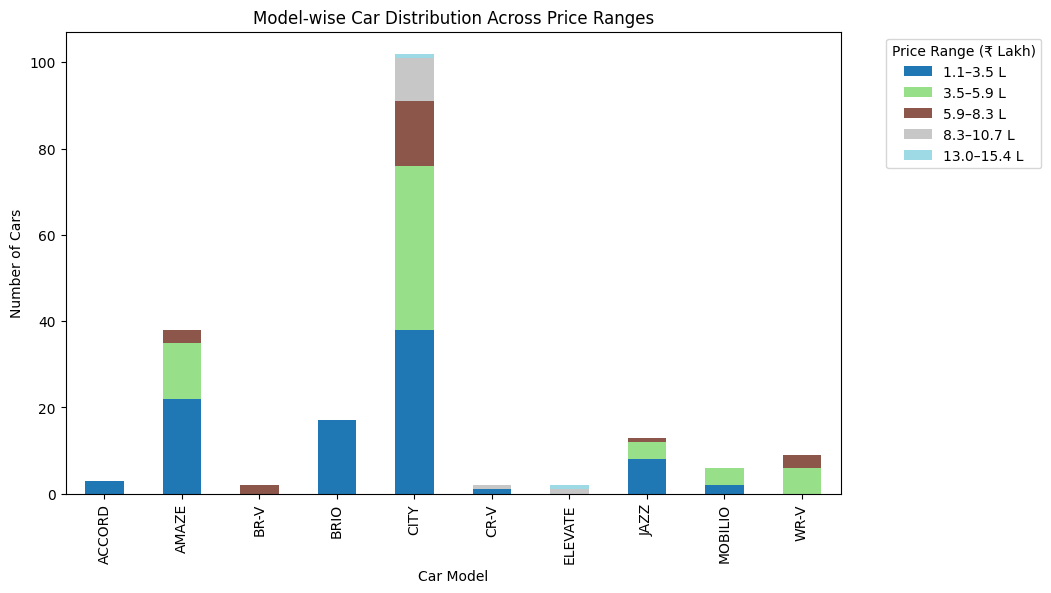

In [ ]:
# Count how many cars of each model fall into each price range
model_price = pd.crosstab(df_cars_clean['model'], df_cars_clean['price_range'])

# Plot stacked bar chart
model_price.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab20')
plt.title('Model-wise Car Distribution Across Price Ranges')
plt.xlabel('Car Model')
plt.ylabel('Number of Cars')
plt.legend(title='Price Range (₹ Lakh)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

**INSIGHTS**

Honda City dominates ₹7–10 L range.

Honda Amaze is mostly ₹5–7 L.

Honda CR-V and Civic appear above ₹15 L.